## Fast multiplexed superconducting qubit readout with intrinsic Purcell filtering

Here we aim to reproduce the main results presented in [this paper](https://arxiv.org/abs/2409.04967) by using QuLTRA. The core idea is to design a notch filter at the qubit frequency by coupling the readout resonator and the filter resonator through a mutual inductive (MTL) coupling. The article provides almost all the necessary elements to recreate this circuit in QuLTRA. We extract the qubit capacitance, inductance, and coupling capacitance from the mode frequency and anharmonicity. The lengths of the resonators and the coupler, along with the widths and gaps of the transmission lines, are explicitly reported in the paper.

In the first task, after defining all the design parameters, we will show the Purcell decay as a function of the qubit inductance variation. The results demonstrate that when the qubit frequency is aligned with the notch frequency, the Purcell decay becomes significantly enhanced.



In [1]:
import numpy as np
import qultra as qu

In [2]:
e = 1.60217657e-19  # electron charge
h = 6.62606957e-34  # Plank's

alpha=326e6
f=8.032e9

C=e**2/2/h/alpha #Cj+Cg
L=1/C/(2*np.pi*f)**2 #Lj

print(C/1e-15)
print(L/1e-9)


59.41788181803965
6.608086177178166


In [2]:
Cj=55.5e-15
L=6.6e-9
Cg=4e-15
Ck=10e-15 #coupling to the feedline

#all these values are available in the original article
Z0=66
gap=[7.5,7.5,7.5,7.5]
width=[5,5.5,5]

#l_r0=974e-6
#l_rs=1617e-6
#l_p0=759e-6
#l_ps=1659e-6
#l_c=318e-6


l_r0=(964+35/2)*1e-6
l_rs=(1607+35/2)*1e-6
l_p0=(749+35/2)*1e-6
l_ps=(1649+35/2)*1e-6
l_c=(300+35)*1e-6


print(l_p0,l_ps,l_c)

0.0007664999999999999 0.0016665 0.000335


In [4]:
variations = np.linspace(-0.5, 0.5, 60) #percentage variation
Tp=[]
for var in variations:
    Lj=L+L*var
    net=[qu.C(0,1,Cj),qu.J(0,1,Lj),qu.C(1,2,Cg),qu.CPW(2,3,l_r0,Z0),qu.CPW_coupler([3,4,5,6],gap,width,l_c),qu.CPW(4,0,l_rs,Z0),qu.CPW(5,7,l_p0,Z0),qu.CPW(6,0,l_ps,Z0),qu.C(7,8,Ck),qu.R(8,0,50)]
    complete_notch=qu.QCircuit(net,5,12)
    k=complete_notch.kappa()
    Tp.append(1/2/np.pi/(k[0]*1e6)) #take qubit kappa

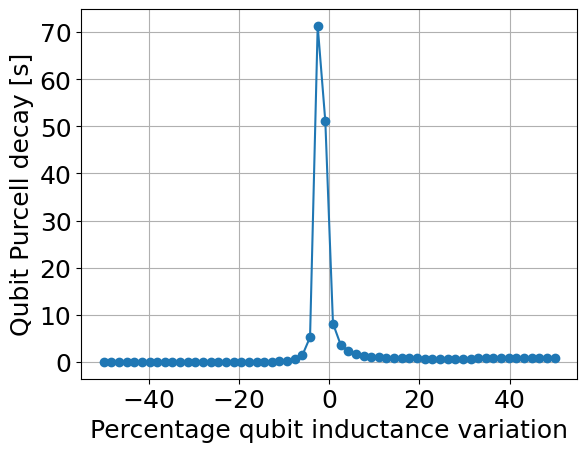

In [5]:
import matplotlib.pyplot as plt

plt.plot(variations*100, Tp, marker='o')
plt.xlabel('Percentage qubit inductance variation', fontsize=18)
plt.ylabel('Qubit Purcell decay [s]',fontsize=18)
#plt.title('Qubit Purcell decay vs Qubit inductance Variation',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

In [6]:
i=np.argmax(np.array(Tp))
Lj=L+L*variations[i]

net=[qu.C(0,1,Cj),qu.J(0,1,Lj),qu.C(1,2,Cg),qu.CPW(2,3,l_r0,Z0),qu.CPW_coupler([3,4,5,6],gap,width,l_c),qu.CPW(4,0,l_rs,Z0),qu.CPW(5,7,l_p0,Z0),qu.CPW(6,0,l_ps,Z0),qu.C(7,8,Ck),qu.R(8,0,50)]
complete_notch=qu.QCircuit(net,5,12)
complete_notch.show_all()

print('Purcell decay time for the optimal resonator length: ', Tp[i], 's')

+------+------------+-----------+-----------+
| Mode | Freq [GHz] |  k [MHz]  |     Q     |
+------+------------+-----------+-----------+
|  1   |  8.12e+00  | -2.23e-09 | -3.64e+12 |
|  2   |  9.94e+00  | -6.73e-02 | -1.48e+05 |
|  3   |  1.04e+01  | -1.83e+01 | -5.66e+02 |
+------+------------+-----------+-----------+
Chi matrix [MHz]:
+------+----------+----------+----------+
| Mode |    1     |    2     |    3     |
+------+----------+----------+----------+
|  1   | 3.19e+02 | 6.70e+00 | 3.06e-02 |
|  2   | 6.70e+00 | 3.52e-02 | 3.22e-04 |
|  3   | 3.06e-02 | 3.22e-04 | 7.35e-07 |
+------+----------+----------+----------+
Purcell decay time for the optimal resonator length:  71.29619458857668 s


The article shows $ Z_{12} $ of the two-port composed only of the two coupled resonators. In the graph, the resonant frequencies of the two resonators and the notch frequency can be clearly identified. Here, we aim to reproduce the same result. After constructing the circuit, we will compute the total admittance matrix, from which we will extract the impedance matrix of the two-port, in order to demonstrate that QuLTRA provides consistent results.


In [2]:
Z0=66
gap=[7.5,7.5,7.5,7.5]
width=[5,5.5,5]

l_r0=(964+35/2)*1e-6
l_rs=(1607+35/2)*1e-6
l_p0=(749+35/2)*1e-6
l_ps=(1649+35/2)*1e-6
l_c=(300+35)*1e-6

net=[qu.CPW(1,2,l_r0,Z0),qu.CPW_coupler([2,3,4,5],gap,width,l_c),qu.CPW(3,0,l_rs,Z0),qu.CPW(4,6,l_p0,Z0),qu.CPW(5,0,l_ps,Z0)]
eth_notch=qu.QCircuit(net,6,12)

In [3]:
l1=l_r0+l_c+l_rs
print(l1)

l2=l_p0+l_c+l_ps
print(l2)
l3=2.874e-3

c=3e8
eff=(1+11.9)/2

f1=c/np.sqrt(eff)/4/l3
f2=c/np.sqrt(eff)/4/l2

print(f1/1e9)
print(f2/1e9)

0.002941
0.002768
10.275303117930035
10.668793772012613


In [56]:
frequencies=np.arange(6,12,0.001)
#frequencies=np.linspace(6,12,5001)
port=[0,5]
Z_12=[]
for f in frequencies:
    Y=eth_notch.build_total_Y_matrix(1j*2*np.pi*1e9*f)
    Z=np.linalg.inv(Y)
    Z_submatrix=np.zeros((len(port),len(port)),dtype=complex)
    for i in range(len(port)):
        for j in range(len(port)):
            Z_submatrix[i,j]=Z[port[i],port[j]]

    Z_12.append((abs(Z_submatrix[1,0].imag)))

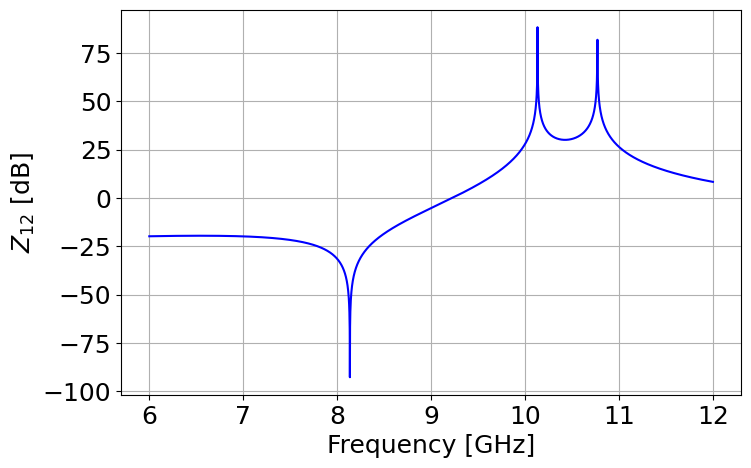

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(frequencies, Z_12, '-', color='blue')


# Etichette e legenda
plt.xlabel('Frequency [GHz]', fontsize='18')
plt.ylabel('$Z_{12}$ [dB]', fontsize='18')
plt.grid(True)
#plt.tight_layout()
plt.xticks(fontsize='18')
plt.yticks(fontsize='18')


# Mostra il grafico
plt.show()

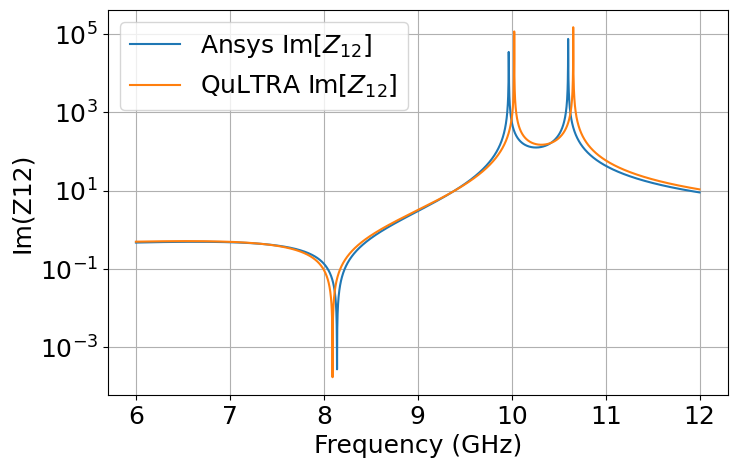

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Percorso al file .tab
file_path =  "C:/Users/simyz/OneDrive - Alma Mater Studiorum Università di Bologna/Desktop/Zurigo1.tab"

# Nomi colonne (inclusa colonna extra vuota finale)
col_names = ['Freq_Hz', 'Z11_Re', 'Z11_Im', 'Z12_Re', 'Z12_Im',
             'Z21_Re', 'Z21_Im', 'Z22_Re', 'Z22_Im','Extra']

# Caricamento dati saltando le righe di intestazione
df = pd.read_csv(file_path, sep='\t', skiprows=2, names=col_names, engine='python')

# Conversione frequenza in GHz
freq_GHz = df['Freq_Hz'] / 1e9

# Parte immaginaria di Z12
Z12_imag = df['Z12_Im'].values

# Modulo della parte immaginaria in dB
Z12_imag_dB = (np.abs(Z12_imag))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(freq_GHz, Z12_imag_dB, label='Ansys Im[$Z_{12}$]')
plt.plot(frequencies, Z_12, '-',label="QuLTRA Im[$Z_{12}$]")
plt.xlabel('Frequency (GHz)',fontsize=18)
plt.ylabel('Im(Z12)',fontsize=18)
#plt.title('Modulo della parte immaginaria di Z12 in dB vs Frequenza')
plt.grid(True)
plt.legend(fontsize='18')
plt.xticks(fontsize='18')
plt.yticks(fontsize='18')
plt.yscale('log')
#plt.tight_layout()
plt.show()
